In [345]:
import numpy as np
import pandas as pd


import datetime as dt
from pylab import mpl, plt
from itertools import product

In [346]:
raw = pd.read_csv('datos\\tr_eikon_eod_data.csv',
                  index_col=0, parse_dates=True)

In [347]:
raw.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1972 entries, 2010-01-04 to 2017-10-31
Data columns (total 12 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AAPL.O  1972 non-null   float64
 1   MSFT.O  1972 non-null   float64
 2   INTC.O  1972 non-null   float64
 3   AMZN.O  1972 non-null   float64
 4   GS.N    1972 non-null   float64
 5   SPY     1972 non-null   float64
 6   .SPX    1972 non-null   float64
 7   .VIX    1972 non-null   float64
 8   EUR=    1972 non-null   float64
 9   XAU=    1972 non-null   float64
 10  GDX     1972 non-null   float64
 11  GLD     1972 non-null   float64
dtypes: float64(12)
memory usage: 200.3 KB


In [348]:
symbol = 'AAPL.O'
data = pd.DataFrame(raw[symbol]).dropna()

In [349]:
SMA1 = 42
SMA2 = 252

<Axes: xlabel='Date'>

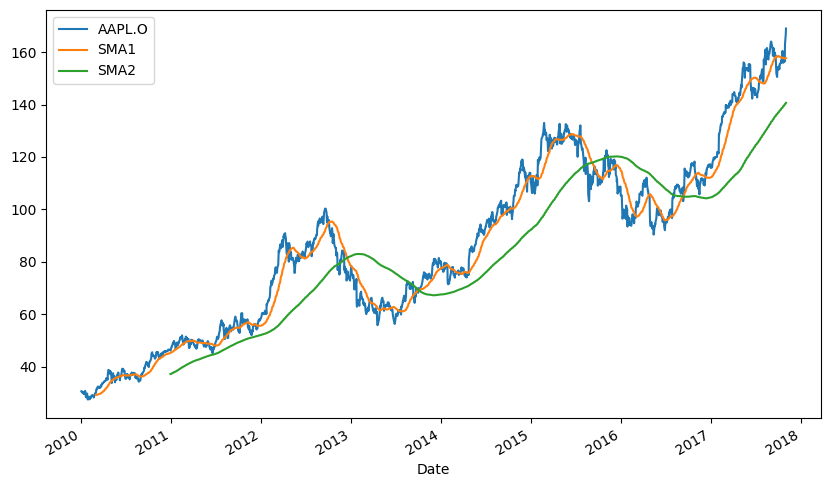

In [350]:
# Calcula las medias moviles
data['SMA1'] = data[symbol].rolling(window=SMA1).mean()
data['SMA2'] = data[symbol].rolling(window=SMA2).mean()
data.plot(figsize=(10, 6))

In [351]:
data.dropna(inplace=True)

In [352]:
# Cuando la media movil de 42 dias es mayor que la de 252 dias, se compra, si no es short
data['Position'] = np.where(data['SMA1'] > data['SMA2'], 1, -1)

In [353]:
data.tail()

,AAPL.O,SMA1,SMA2,Position
Date,,,,
2017-10-25,156.41,157.610952,139.862520,1
2017-10-26,157.41,157.514286,140.028472,1
2017-10-27,163.05,157.517619,140.221210,1
2017-10-30,166.72,157.597857,140.431528,1
2017-10-31,169.04,157.717857,140.651766,1


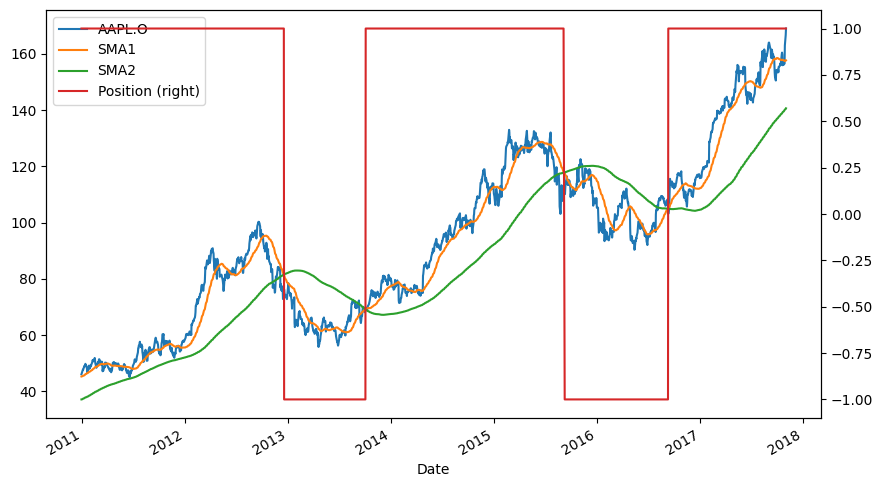

In [354]:
# Grafica la posicion en el eje secundario
ax = data.plot(secondary_y='Position', figsize=(10, 6))

In [355]:
data['Returns'] = np.log(data[symbol] / data[symbol].shift(1))
data['Strategy'] = data['Position'].shift(1) * data['Returns']


data.round(4).head()

,AAPL.O,SMA1,SMA2,Position,Returns,Strategy
Date,,,,,,
2010-12-31,46.0800,45.2810,37.1207,1,NaN,NaN
2011-01-03,47.0814,45.3497,37.1862,1,0.0215,0.0215
2011-01-04,47.3271,45.4126,37.2525,1,0.0052,0.0052
2011-01-05,47.7142,45.4661,37.3223,1,0.0081,0.0081
2011-01-06,47.6757,45.5226,37.3921,1,-0.0008,-0.0008


In [356]:
data.dropna(inplace=True)

In [357]:
# Calcula el rendimiento acumulado
np.exp(data[['Returns', 'Strategy']].sum())

Returns     3.668406
Strategy    5.306802
dtype: float64

In [358]:
# Calcula la volatilidad anualizada
data[['Returns', 'Strategy']].std() * 252 ** 0.5

Returns     0.252947
Strategy    0.252763
dtype: float64

<Axes: >

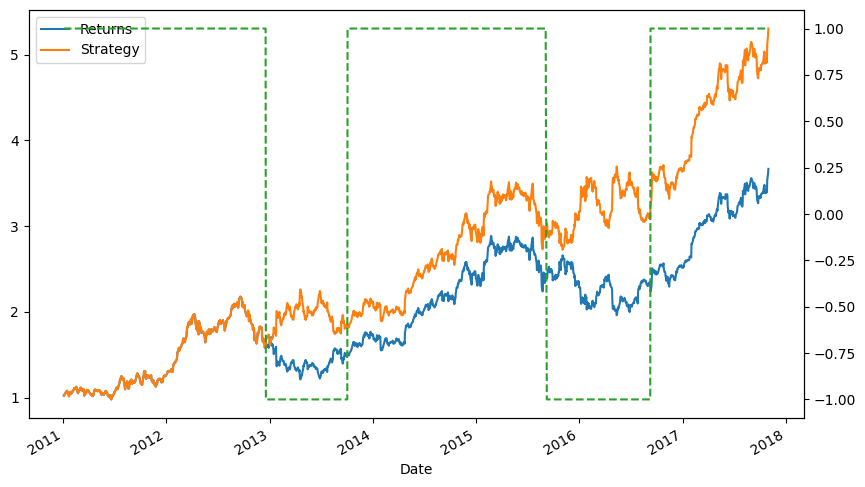

In [359]:
ax = data[['Returns', 'Strategy']].cumsum().apply(np.exp).plot(figsize=(10, 6))
data['Position'].plot(ax=ax, secondary_y='Position', style='--')

In [360]:
from itertools import product

In [361]:
sma1 = range(20, 61, 4)
sma2 = range(180, 281, 10)

In [362]:
data.head()

,AAPL.O,SMA1,SMA2,Position,Returns,Strategy
Date,,,,,,
2011-01-03,47.081381,45.349708,37.186246,1,0.021500,0.021500
2011-01-04,47.327096,45.412599,37.252521,1,0.005205,0.005205
2011-01-05,47.714238,45.466102,37.322266,1,0.008147,0.008147
2011-01-06,47.675667,45.522565,37.392079,1,-0.000809,-0.000809
2011-01-07,48.017095,45.582089,37.462453,1,0.007136,0.007136


In [363]:
results = pd.DataFrame()
for SMA1, SMA2 in product(sma1, sma2):
    data = pd.DataFrame(raw[symbol]).dropna()
    data['SMA1'] = data[symbol].rolling(window=SMA1).mean()
    data['SMA2'] = data[symbol].rolling(window=SMA2).mean()
    data['Returns'] = np.log(data[symbol] / data[symbol].shift(1))
    data.dropna(inplace=True)

    data['Position'] = np.where(data['SMA1'] > data['SMA2'], 1, -1)
    data['Strategy'] = data['Position'].shift(1) * data['Returns']
    perf = np.exp(data[['Returns', 'Strategy']].sum())
    new_row = pd.DataFrame(
        {'SMA1': SMA1, 'SMA2': SMA2,
         'MARKET': perf['Returns'], 'STRATEGY': perf['Strategy'],
         'OUT': perf['Strategy'] - perf['Returns']},
        index=[0])
    results = pd.concat([results, new_row], ignore_index=True)

In [364]:
results.sort_values('OUT', ascending=False).head()

,SMA1,SMA2,MARKET,STRATEGY,OUT
56,40,190,4.188309,6.552273,2.363963
39,32,240,3.678556,5.989309,2.310753
59,40,220,3.841448,5.976137,2.134689
46,36,200,3.759551,5.834923,2.075371
70,44,220,3.841448,5.908175,2.066727


# Random Walk Hypothesis
Indica que el precio no puede preveerse porque sigue un paso aleatorio

In [365]:
symbol = '.SPX'

data = pd.DataFrame(raw[symbol]).dropna()

In [370]:
lags = 5
cols = []
for lag in range(1, lags + 1):
    col = f'lag_{lag}'
    data[col] = data[symbol].shift(lag)
    cols.append(col)

['lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5']
